In [1]:
# 导入需要的模块
# 若无相关module, 可以在jupyter note中可以 ! pip install <模块名>
import requests
import re
import numpy as np
import pandas as pd
import matplotlib as plt
from bs4 import BeautifulSoup
import datetime
import backtrader as bt
import pandas as pd
import yfinance as yf

In [2]:
# 定义获取天天基金html的函数
# 该函数也是参考别的大神写的
# 该函数用于访问指定url，即按照基金代码、开始和截止日期访问到相应的页面
def get_html(code, start_date, end_date, page=1, per=20):
    ''' 需要输入的参数为code:即基金代码，starte_date: 开始日期'''
    '''end_date：结束日期'''
    url = 'http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&code={0}&page={1}&sdate={2}&edate={3}&per={4}'.format(
        code, page, start_date, end_date, per)
    rsp = requests.get(url)
    html = rsp.text
    return html


# 定义获取基金数值的函数
# 通过上文的get_html函数访问到相应的页面后，需要通过beautifulsoup对html页面进行解析
# 解析后的数据写入dataframe, 并进行返回
def get_fund(code, start_date, end_date, page=1, per=20):
    # 获取html
    html = get_html(code, start_date, end_date, page, per)
    soup = BeautifulSoup(html, 'html.parser')
    # 获取总页数
    pattern = re.compile('pages:(.*),')
    result = re.search(pattern, html).group(1)
    total_page = int(result)
    # 获取表头信息
    heads = []
    for head in soup.findAll("th"):
        heads.append(head.contents[0])
 
 
    # 数据存取列表
    records = []
    # 获取每一页的数据
    current_page = 1
    while current_page <= total_page:
        html = get_html(code, start_date, end_date, current_page, per)
        soup = BeautifulSoup(html, 'html.parser')
        # 获取数据
        for row in soup.findAll("tbody")[0].findAll("tr"):
            row_records = []
            for record in row.findAll('td'):
                val = record.contents
                # 处理空值
                if val == []:
                    row_records.append(np.nan)
                else:
                    row_records.append(val[0])
            # 记录数据
            records.append(row_records)
        # 下一页
        current_page = current_page + 1
 
 
    # 将数据转换为Dataframe对象
    np_records = np.array(records)
    fund_df = pd.DataFrame()
    for col, col_name in enumerate(heads):
        fund_df[col_name] = np_records[:, col]
 
 
    # 按照日期排序
    fund_df['净值日期'] = pd.to_datetime(fund_df['净值日期'])
    fund_df = fund_df.sort_values(by='净值日期', axis=0, ascending=True).reset_index(drop=True)
    fund_df = fund_df.set_index('净值日期')
 
 
    # 数据类型处理
    fund_df['单位净值'] = fund_df['单位净值'].astype(float)
    fund_df['累计净值'] = fund_df['累计净值'].astype(float)
    fund_df['日增长率'] = fund_df['日增长率'].str.strip('%').astype(float)
    return fund_df

In [4]:
#需要获取的基金代码
my_dict={'中债综指':'161119',
     '黄金':'000217',
     '标普500':'050025',
     '纳100':'270042',
        "中证红利":"090010"}

# 此代码用于将上文提及的基金名称、代码等，由字典类型转换成 dataframe类型
my_df = pd.DataFrame.from_dict(my_dict, orient='index',columns=['code'])
my_df=my_df.reset_index().rename(columns={'index':'name'})

In [6]:
# 先创立一个local化的变量，用于在for循环中自动创建dataframe
fund_df_=locals()
for i in range(len(my_df)):
    # 根据输入的基金名称和数量，自动创建相应个数的dataframe
    fund_df_[my_df['code'][i]]=pd.DataFrame()
    # # fund_df_[my_df['code'][i]] = pd.read_excel(my_df['name'][i]+'.xlsx',index_col=0)
    # # 获取基金数据
    fund_df_[my_df['code'][i]]=get_fund(my_df['code'][i],start_date='2014-10-21',end_date='2024-10-28')
    # 将基金数据作为xlsx文件写入本地
    # fund_df_[my_df['code'][i]].to_excel(my_df['name'][i]+'.xlsx')

In [9]:
class AnnualRebalanceStrategy(bt.Strategy):
    params = (
        ("allocations", {
            "161119": 0.55,
            "000217": 0.15,
            "050025": 0.10,
            "270042": 0.10,
            "090010": 0.10
        }),
    )

    def __init__(self):
        self.last_rebalance = None
        self.portfolio_values = {}
        self.factor_exposures = {}
        self.factor_returns = {}
        self.positions_tracker = {}

    def log(self, txt, dt=None):
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print("%s, %s" % (dt.date(), txt))

    def next(self):
        current_date = self.data.datetime.date()
        total_value = self.broker.getvalue()
        self.portfolio_values[current_date] = total_value
        self.calculate_factor_exposures()

        # Store positions for each asset
        positions_snapshot = {}
        for d in self.datas:
            position = self.getposition(d)
            current_value = position.size * d.close[0]
            positions_snapshot[d._name] = current_value

        positions_snapshot['cash']= self.broker.get_cash()
        self.positions_tracker[current_date] = positions_snapshot

        if self.last_rebalance is None or current_date.year > self.last_rebalance.year:
            self.log(f"Rebalancing on {current_date}")
            self.rebalance_portfolio()
            self.last_rebalance = current_date

    def calculate_factor_exposures(self):
        total_value = self.broker.getvalue()
        exposures = {}
        for d in self.datas:
            current_value = d.close[0] * self.broker.getposition(d).size
            exposures[d._name] = current_value / total_value
        self.factor_exposures[self.data.datetime.date()] = exposures

    def rebalance_portfolio(self):
        total_value = self.broker.getvalue()
        
        for d in self.datas:
            ticker = d._name
            target_allocation = self.p.allocations.get(ticker, 0)
            target_value = total_value * target_allocation
            
            position = self.getposition(d)
            current_value = position.size * d.close[0]
            units_to_trade = (target_value - current_value) / d.close[0]
    
            if units_to_trade > 0:
                self.buy(data=d, size=units_to_trade,price=d.close[0])
                self.log(f'Buying {units_to_trade} units of {d._name} at {d.close[0]}')
            elif units_to_trade < 0:
                self.sell(data=d, size=abs(units_to_trade),price=d.close[0])
                self.log(f'Selling {abs(units_to_trade)} units of {d._name} at {d.close[0]}')

        # Check positions after rebalancing
        for d in self.datas:
            position = self.getposition(d)
            self.log(f'Post-Rebalance Position for {d._name}: Size: {position.size}, Price: {d.close[0]}')

    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.log(f'Order executed: {order.data._name}, Price: {order.executed.price}, Size: {order.executed.size}')
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'Order failed: {order.data._name}, Status: {order.getstatusname()}')

class CustomFundData(bt.feeds.PandasData):
    # Define the columns you want to use, and set the corresponding line to None if you don't want to use it
    lines = ('nav', 'close', 'daily_growth_rate')

    params = (
        ('datetime', None),  # This field is not used because the index is the date
        ('nav', 0),          # Map 'nav' to the first column (单位净值)
        ('close', 1),      # Map 'close' to the second column (累计净值)
        ('daily_growth_rate', 2),  # Map 'daily_growth_rate' to the third column (日增长率)
    )


if __name__ == "__main__":
    cerebro = bt.Cerebro()

    # Add the data feeds for each stock
    tickers = ["161119",
            "000217",
            "050025",
            "270042",
            "090010"]
    for ticker in tickers:
        df = fund_df_[ticker].iloc[:,0:3]
        df.columns=['nav', 'close', 'daily_growth_rate']
         # Ensure all numeric fields are floats
        df['nav'] = pd.to_numeric(df['nav'], errors='coerce')
        df['close'] = pd.to_numeric(df['close'], errors='coerce')
        df['open'] = df.close.shift(1)
        df['open'] = df['open'].fillna(method='backfill')
        df['daily_growth_rate'] = pd.to_numeric(df['daily_growth_rate'], errors='coerce')
        
        # Handle NaN values
        df.fillna(0, inplace=True)
        
        data = CustomFundData(dataname=df)
        cerebro.adddata(data, name=ticker)

    cerebro.addstrategy(AnnualRebalanceStrategy)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.broker.setcash(1000000)

    # Execute the backtest
    results = cerebro.run()

    # Access the strategy instance
    strategy = results[0]

    # Convert portfolio_values and factor_exposures to DataFrames
    portfolio_df = pd.DataFrame(list(strategy.portfolio_values.items()), columns=['Date', 'TotalValue'])
    portfolio_df.set_index('Date', inplace=True)

    factor_exposures_df = pd.DataFrame(strategy.factor_exposures).T

    print("Portfolio Values:\n", portfolio_df.head())
    print("Factor Exposures:\n", factor_exposures_df.head())


C:\Users\wenyuan\AppData\Local\Temp\ipykernel_27736\2883742301.py:112: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['open'] = df['open'].fillna(method='backfill')
C:\Users\wenyuan\AppData\Local\Temp\ipykernel_27736\2883742301.py:112: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['open'] = df['open'].fillna(method='backfill')
C:\Users\wenyuan\AppData\Local\Temp\ipykernel_27736\2883742301.py:112: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['open'] = df['open'].fillna(method='backfill')
C:\Users\wenyuan\AppData\Local\Temp\ipykernel_27736\2883742301.py:112: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['open'] = df['open'].fi

2014-10-21, Rebalancing on 2014-10-21
2014-10-21, Buying 525661.8560642264 units of 161119 at 1.0463
2014-10-21, Buying 163755.45851528383 units of 000217 at 0.916
2014-10-21, Buying 71428.57142857143 units of 050025 at 1.4
2014-10-21, Buying 73909.83000739098 units of 270042 at 1.353
2014-10-21, Buying 109409.19037199124 units of 090010 at 0.914
2014-10-21, Post-Rebalance Position for 161119: Size: 0, Price: 1.0463
2014-10-21, Post-Rebalance Position for 000217: Size: 0, Price: 0.916
2014-10-21, Post-Rebalance Position for 050025: Size: 0, Price: 1.4
2014-10-21, Post-Rebalance Position for 270042: Size: 0, Price: 1.353
2014-10-21, Post-Rebalance Position for 090010: Size: 0, Price: 0.914
2014-10-22, Order executed: 161119, Price: 1.0463, Size: 525661.8560642264
2014-10-22, Order executed: 000217, Price: 0.9160000000000001, Size: 163755.45851528383
2014-10-22, Order executed: 050025, Price: 1.4, Size: 71428.57142857143
2014-10-22, Order executed: 270042, Price: 1.353, Size: 73909.83000

D:\Python\Lib\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.76%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2014-10-21
End date,2024-10-21
Total months,116
,Backtest
Annual return,8.76%
Cumulative returns,125.474%
Annual volatility,5.437%
Sharpe ratio,1.57
Calmar ratio,1.03
Stability,0.98
Max drawdown,-8.512%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.51,2020-02-21,2020-03-23,2020-05-18,62
1,6.40,2015-06-12,2015-08-25,2015-12-29,143
2,5.87,2022-01-04,2022-06-16,2023-03-30,323
3,3.89,2020-09-02,2020-09-24,2021-01-20,101
4,3.59,2024-07-16,2024-08-07,2024-09-24,51


D:\Python\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Oct14,0.08%,-0.25%,0.51%
Fall2015,-0.14%,-1.61%,0.88%
New Normal,0.03%,-1.61%,1.42%
Covid,0.03%,-3.24%,2.50%


Top 10 long positions of all time,max
090010,100.00%


Top 10 short positions of all time,max


Top 10 positions of all time,max
090010,100.00%


D:\Python\Lib\site-packages\pyfolio\pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
D:\Python\Lib\site-packages\pyfolio\pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
D:\Python\Lib\site-packages\pyfolio\plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
D:\Python\Lib\site-packages\pyfolio\plotting.py:1465: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_turnover_by_month = df_turnover.resample("M").mean()


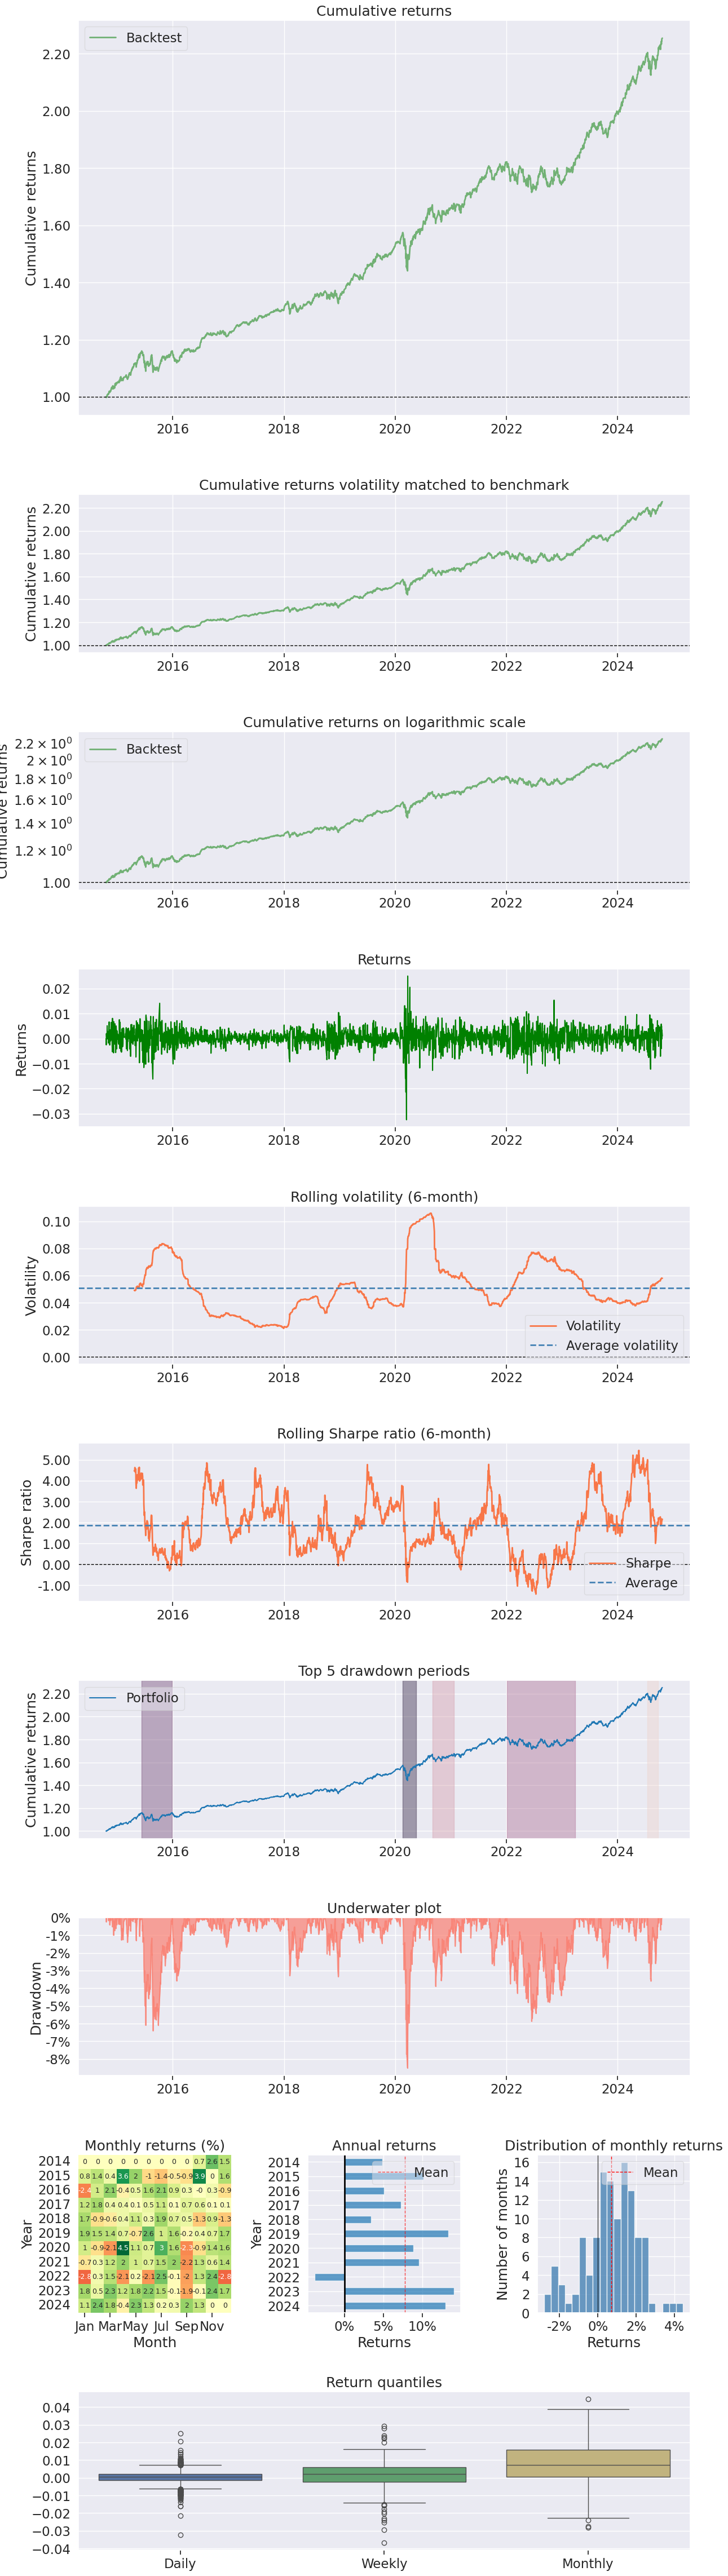

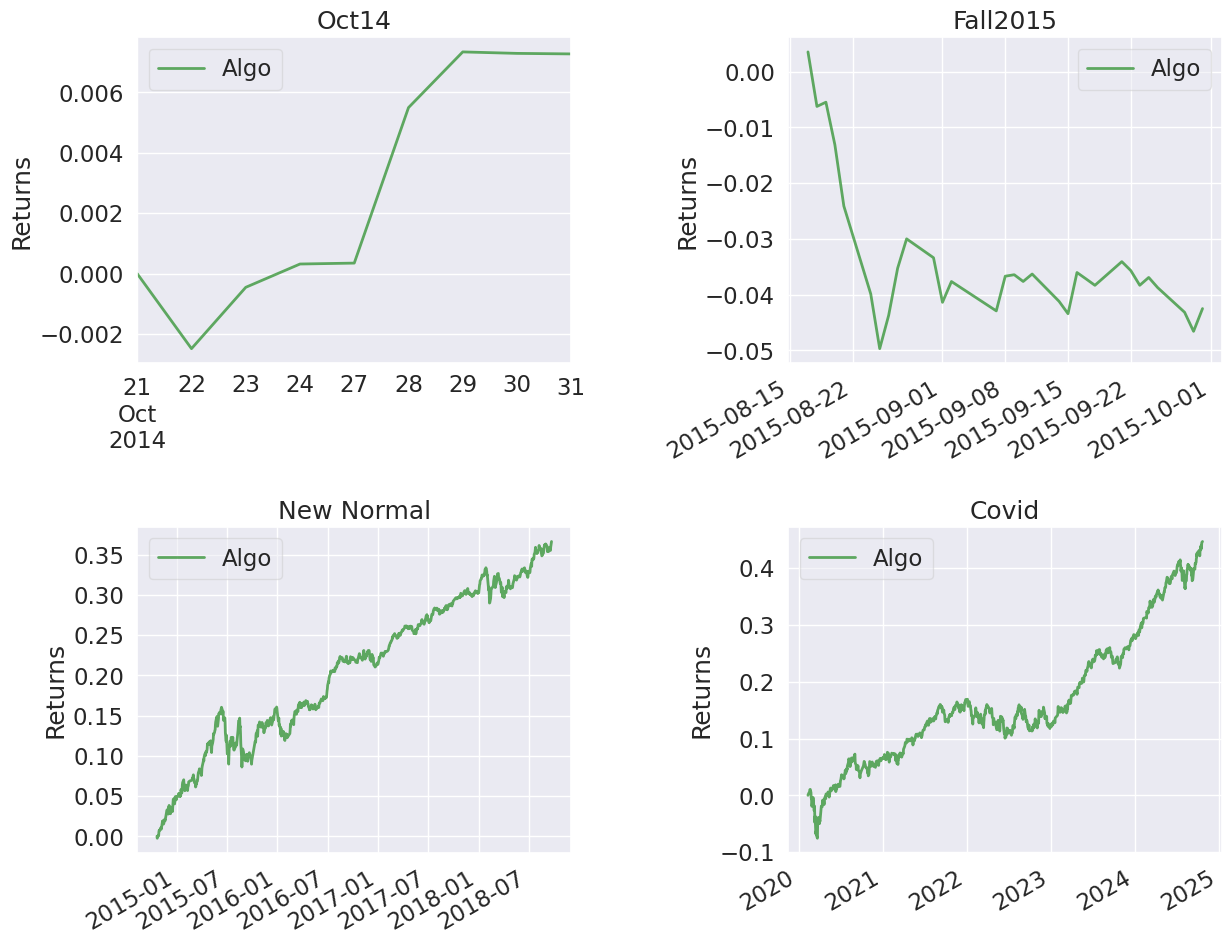

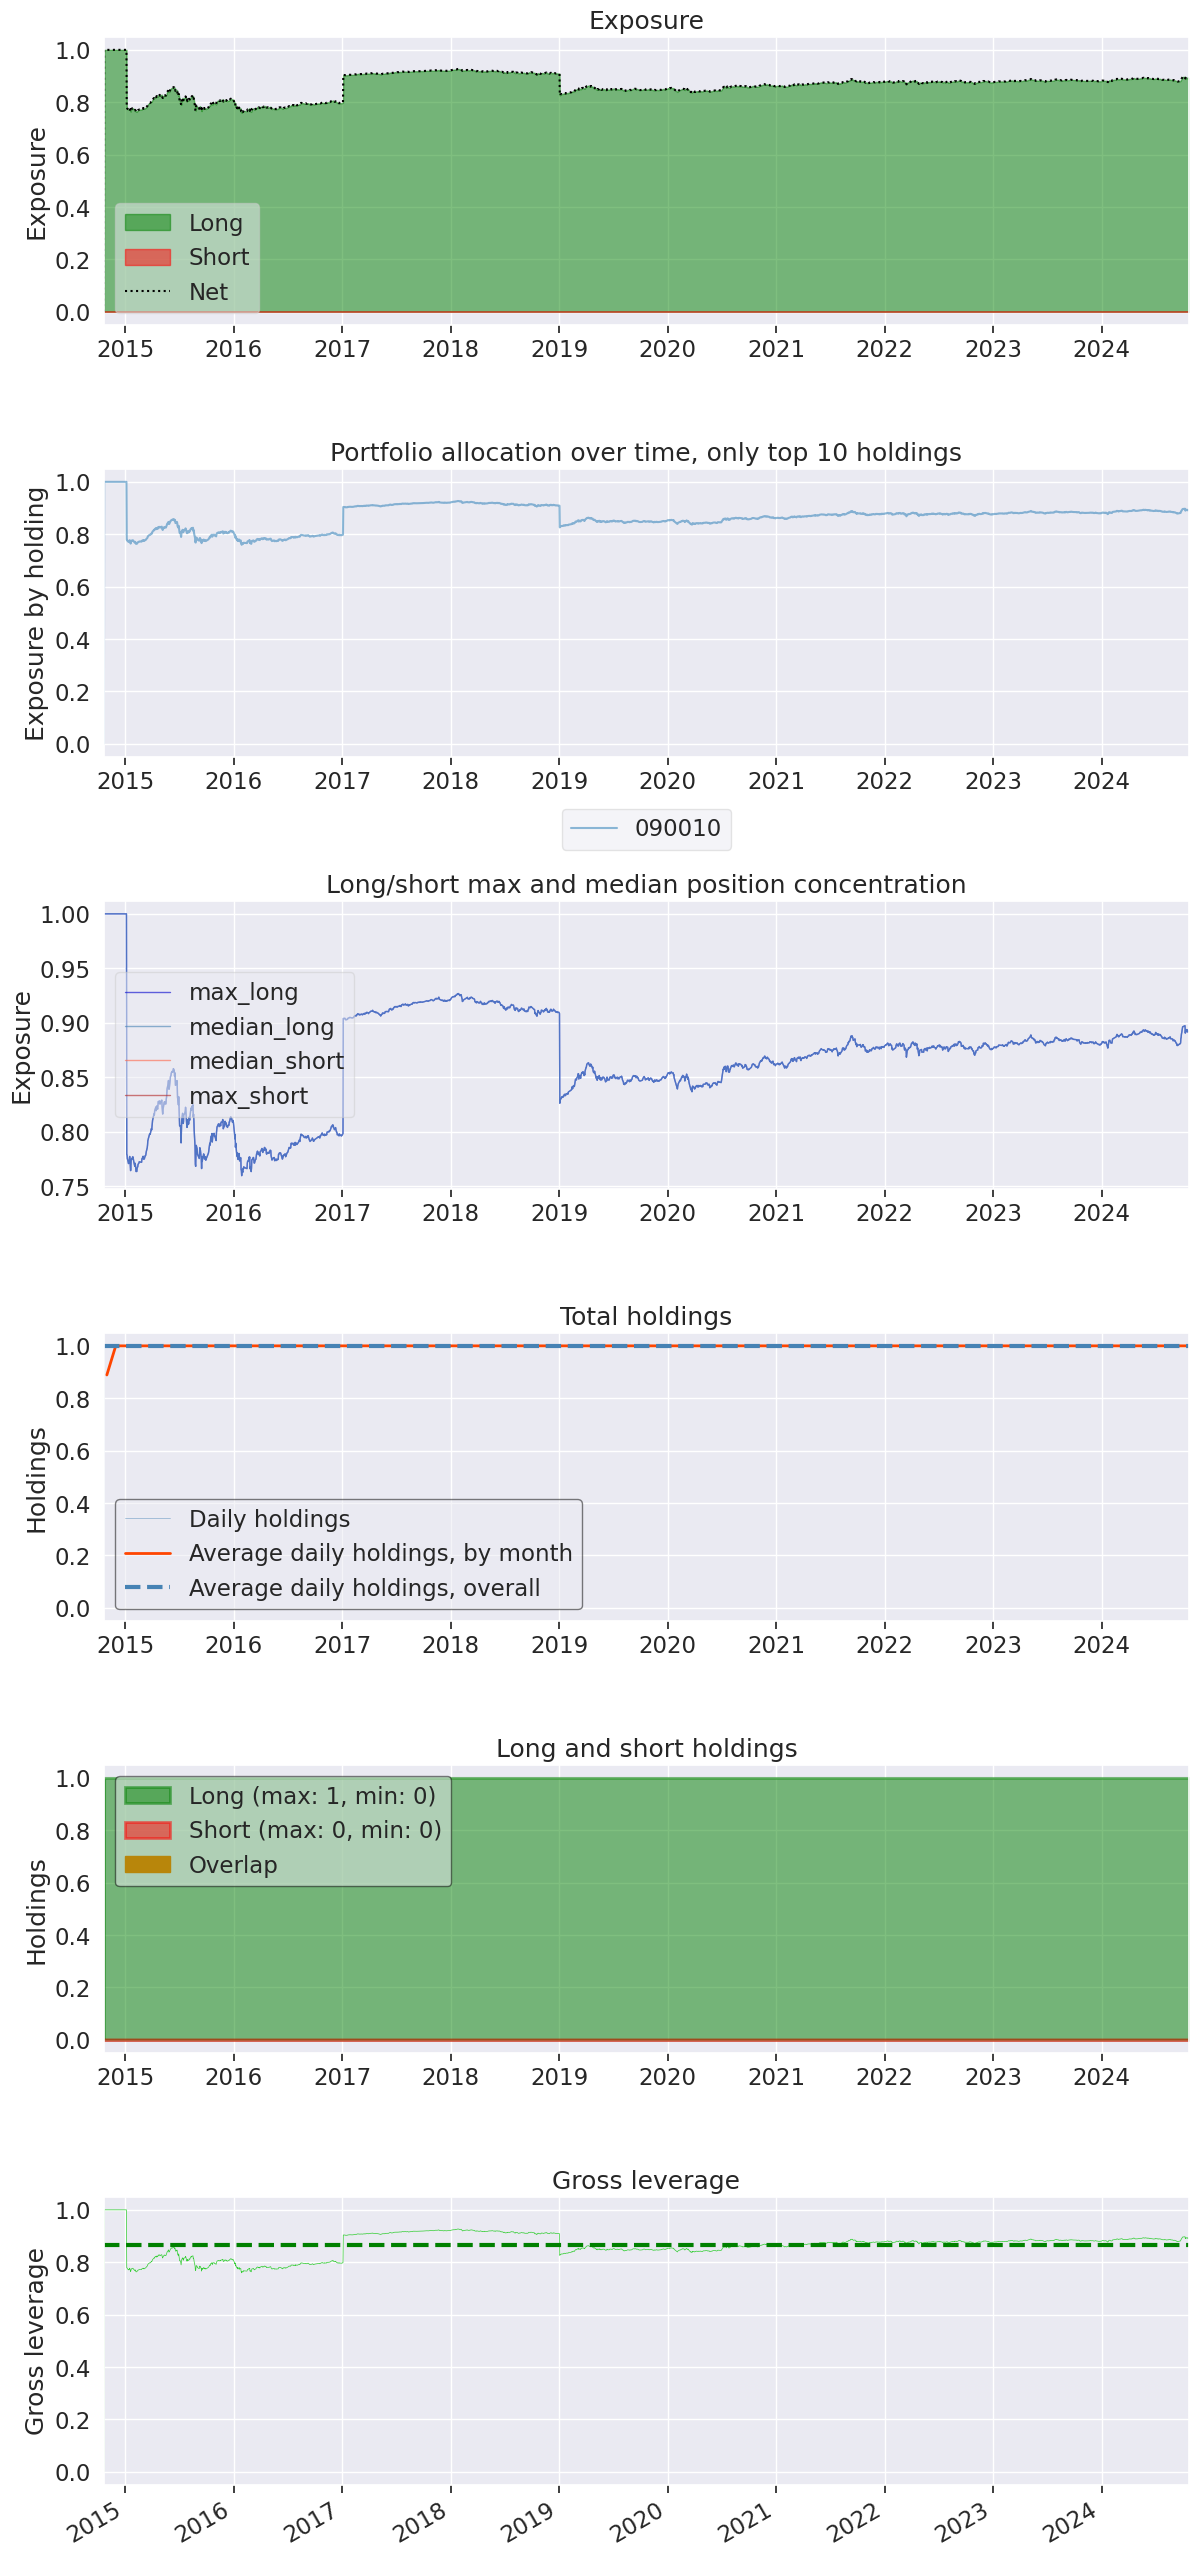

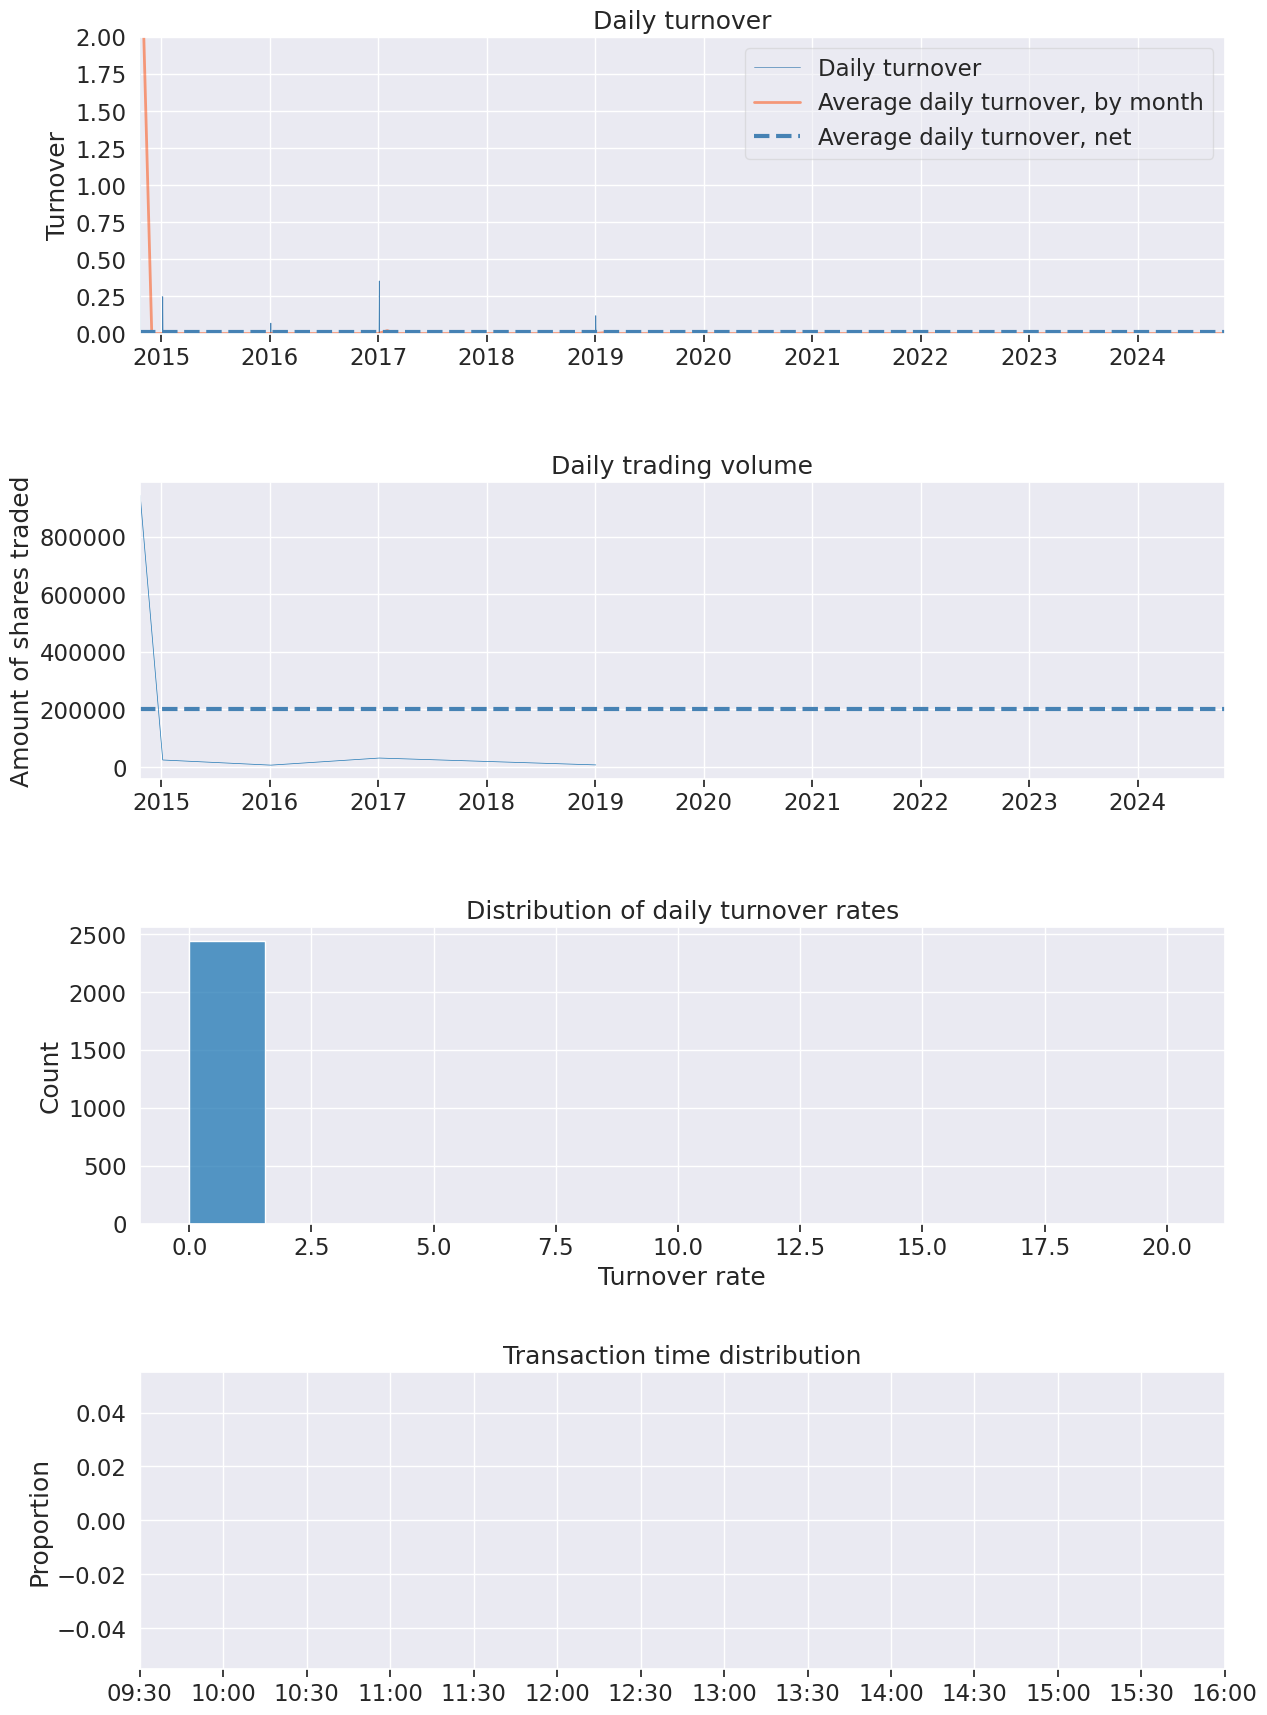

In [11]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
# pyfolio showtime
import pyfolio as pf
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions)

# At this point tables and chart will show up

In [31]:
import quantstats_lumi as qs
qs_returns = returns
qs_returns.index = qs_returns.index.tz_localize(None)
qs.reports.html(qs_returns,
                rf=0.03,
                title='All Weather Strategy Tearsheet',
                periods_per_year=365,
                download_filename='All Weather Strategy quantstats-tearsheet.html')

In [22]:
returns.index.tz_localize(None)

DatetimeIndex(['2014-10-21', '2014-10-22', '2014-10-23', '2014-10-24',
               '2014-10-27', '2014-10-28', '2014-10-29', '2014-10-30',
               '2014-10-31', '2014-11-03',
               ...
               '2024-10-08', '2024-10-09', '2024-10-10', '2024-10-11',
               '2024-10-14', '2024-10-15', '2024-10-16', '2024-10-17',
               '2024-10-18', '2024-10-21'],
              dtype='datetime64[ns]', name='index', length=2440, freq=None)